In [1]:
import os
import re
import pandas as pd
from pandasql import sqldf
from date_processing import *

pysqldf = lambda q: sqldf(q, globals())

In [2]:
ETF_data_file = 'history/NDX.csv'
date_column = 'Date'
price_column = 'Close'

hold_duration_years = 15
hold_duration_days = 252*hold_duration_years

output_excel_file = 'results/qqq_cost_averaging_{}y.xlsx'.format(hold_duration_years)

In [3]:
start_date = '0000-01-01'
end_date = '9999-01-01'

In [4]:
if '.csv' in ETF_data_file.lower():
    data = pd.read_csv(
        ETF_data_file,
        )
else:
    data = pd.read_excel(
        ETF_data_file,
        )

data[date_column] = data[date_column].apply(date_normalize)
data[price_column] = data[price_column].apply(str_to_float)

data = pysqldf(u"""
    select 
    {} as date,
    {} as price
    from data
    """.format(
    date_column, 
    price_column
   ))

data = pysqldf(u"""
    select *
    from data
    where date >= '{}' and date <= '{}'
    order by date asc
    """.format(
    start_date, 
    end_date))


data['id'] = data.index

In [5]:
data.tail(3)

,date,price,id
9280,2022-07-27,12601.46973,9280
9281,2022-07-28,12717.87012,9281
9282,2022-07-29,12947.96973,9282


# the return

In [6]:
holding = pysqldf(u"""
    select 
    data.date,
    data.price,
    pre_data.date as pre_date,
    pre_data.price as pre_price
    from data
    join data as pre_data on pre_data.id+{} = data.id
    """.format(hold_duration_days))

In [7]:
holding.tail(3)

,date,price,pre_date,pre_price
5500,2022-07-27,12601.46973,2007-07-23,2036.329956
5501,2022-07-28,12717.87012,2007-07-24,2000.550049
5502,2022-07-29,12947.96973,2007-07-25,2011.140015


In [8]:
window_data = pysqldf(u"""
    select boundary.*,
    window.date as window_date,
    1000.0/window.price as window_shares,
    window.price as window_price
    from holding as boundary
    join data as window
    on window.date >= boundary.pre_date and window.date < boundary.date
    """)

In [9]:
window_aggrated = pysqldf(u"""
    select date, 
    count(*)*1000.0 as invested_amount,
    sum(window_shares) as bought_shares,
    price
    from window_data 
    group by date
    """)

In [10]:
window_ratio =  pysqldf(u"""
    select *,
    bought_shares*price/invested_amount as ratio
    from window_aggrated 
    order by date asc
    """)

In [11]:
window_ratio =  pysqldf(u"""
    select *, 
    bought_shares*price as sold_amount
    from window_ratio
    """)

In [12]:
window_ratio.to_excel(output_excel_file, index = False)

In [13]:
window_ratio.tail(3)

,date,invested_amount,bought_shares,price,ratio,sold_amount
5500,2022-07-27,3780000.0,1144.026331,12601.46973,3.813866,1.441641e+07
5501,2022-07-28,3780000.0,1143.614607,12717.87012,3.847710,1.454434e+07
5502,2022-07-29,3780000.0,1143.193374,12947.96973,3.915882,1.480203e+07


<AxesSubplot:xlabel='date'>

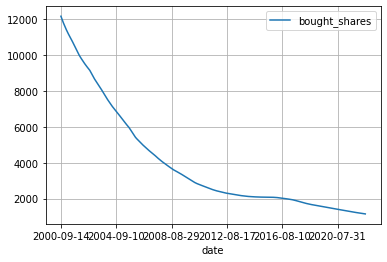

In [14]:
window_ratio.plot(x ='date', y=[
    'bought_shares', 
    ], grid = True)

<AxesSubplot:xlabel='date'>

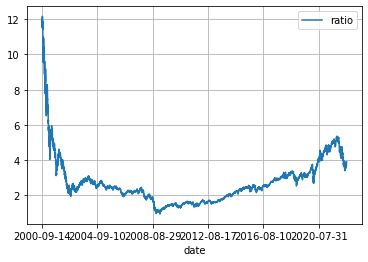

In [15]:
window_ratio.plot(x ='date', y=[
    'ratio', 
    ], grid = True)

In [16]:
window_ratio.tail(3)

,date,invested_amount,bought_shares,price,ratio,sold_amount
5500,2022-07-27,3780000.0,1144.026331,12601.46973,3.813866,1.441641e+07
5501,2022-07-28,3780000.0,1143.614607,12717.87012,3.847710,1.454434e+07
5502,2022-07-29,3780000.0,1143.193374,12947.96973,3.915882,1.480203e+07


<AxesSubplot:>

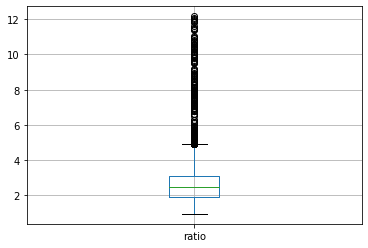

In [17]:
window_ratio.boxplot(column=['ratio']) 

In [18]:
sold_amount = window_ratio['sold_amount'].median()

print('sold_amount:\t%0.4f million'%(sold_amount/1000000))

sold_amount:	9.2635 million


In [19]:
ratio = window_ratio['ratio'].median()

print('Ratio:\t%0.4f'%(ratio))

Ratio:	2.4507


##### END